# Tutorial-01 Intro to longitudinal PID control

虚拟环境配置 Jupyter Notebook 的方法：
1. 安装 ipykernel：'pip install ipykernel'
2. 将当前虚拟环境添加到 ipykernal 中：'python -m ipykernel install --user --name=myenv'

PID 控制，由三种误差调节手段的结果相加而成（比例、积分、微分），其中，比例部分考虑了误差的大小，尝试减少误差；积分部分考虑了误差的累计，尝试消除稳态误差；微分部分考虑了误差的变化率，尝试减少误差的变化。
$$
u = K_P \times e(t) + K_I \times \int_0^t e(\tau) \text{d}\tau + K_D \dot{e}(t)
$$

在实际编程的时候，我们很难用代码去实现连续时间的积分和微分，并且我们并不知道误差的数学表达式，难以得到上述方程的解析解，因此需要将积分和微分离散化：
$$
\begin{align}
&K_p \times e(t) = K_p \times e_k \\
&\int_0^t e(t) \text{d}t = \sum_{i=0}^k e_i \\
&\dot{e}(t) = \frac{e_k - e_{k-1}}{\text{d}t}
\end{align}
$$
完整的公式为：
$$
u = K_P e_k + K_I \sum_{i=0}^k e_i + K_D \frac{e_k - e_{k-1}}{\text{d}t}
$$

In [4]:
class PidController:
    Kp_ = 0 # 比例系数
    Ki_ = 0 # 积分系数
    Kd_ = 0 # 微分系数
    
    previous_error_ = 0 # 上一个控制周期的误差
    accum_error_    = 0 # 累计误差
    
    def __init__(self, Kp, Ki, Kd):
        self.Kp_ = Kp # 初始化比例系数
        self.Ki_ = Ki # 初始化积分系数
        self.Kd_ = Kd # 初始化微分系数
        
    def update_control(self, target_state, current_state, dt):
        # 计算比例项
        error = target_state - current_state
        proportional_term = self.Kp_ * error    

        
        # 计算积分项
        self.accum_error_ += error #* dt  # 累积误差
        integral_term = self.Ki_ * self.accum_error_

        
        # 计算微分项
        error_diff = error - self.previous_error_
        derivative_term = self.Kd_ * (error_diff / dt)

        
        # 计算控制量
        control_signal = proportional_term + integral_term + derivative_term

        self.previous_error_ = error


        # 更新返回值
        return control_signal


假设车辆的油门/刹车指令 $u(t)$ 和车速 $v(t)$ 之间的关系符合一阶惯性环节（这里令 $u(t)>0$ 时表示油门，$u(t)<0$ 时表示刹车）：
$$
\dot{v}(t) = \frac{1}{\Gamma} \cdot (u(t) - v(t))
$$
同 PID 一样，我们需要将上面这个表达式离散化：
$$
\begin{align}
\dot{v}(t) &= \frac{v_{k+1} - v_{k}}{\text{d}t} \\
\Rightarrow v_k{k + 1} &= v_{k} + \dot{v}(t) \text{d}t \\
&= v_{k} + \frac{1}{\Gamma}(u_k - v_k) \cdot \text{d}t
\end{align}
$$


In [5]:
class Vehicle:
    tau_ = 1 # 一阶惯性环节的时间常数
    v_   = 0 # 当前车速
    
    def __init__(self, initial_state):
        self.v_ = initial_state # 初始化当前车速
    
    def update_state(self, u, dt):
        # 根据公式更新车速
        delta_v = (1 / self.tau_) * (u - self.v_) * dt
        self.v_ += delta_v
        
        return self.v_ 

我们接下来可以通过这个简易的车辆模型来测试刚刚创建的 PID 控制器

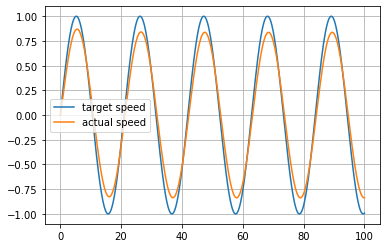

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt

# 初始化车辆
initial_v = 0
vehicle = Vehicle(initial_v) 

# 初始化 PID 控制器
pid = PidController(Kp=4, Ki=0.05, Kd=0.001)

# 设置仿真条件
total_sim_time = 100
sample_time    = 0.1
sim_time       = np.arange(0, total_sim_time, sample_time)

# 初始化用于存储仿真过程信息的数组
target_v_list = np.zeros(len(sim_time) + 1)
actual_v_list = np.ones (len(sim_time) + 1) * initial_v
control_list  = np.zeros(len(sim_time)    )

# 开始仿真
current_v = vehicle.v_
for i in range(len(sim_time)):
    # 计算 sin 函数形式的目标车速
    t = sim_time[i]
    target_v = math.sin(0.3 * t)
    
    # 计算加速度控制量
    accel_cmd = pid.update_control(target_v, current_v, sample_time)
    
    # 更新当前车速
    current_v = vehicle.update_state(accel_cmd, sample_time)
    
    # 记录仿真过程数据
    target_v_list[i + 1] = target_v
    actual_v_list[i + 1] = current_v
    control_list[i] = accel_cmd

# sim_time 的最后一个值为 total_sim_time - sample_time
# 因此这里要手动把 total_sim_time 添加到数组的最后一行
sim_time_extend = np.append(sim_time, total_sim_time)

# 绘制仿真结果
plt.figure(1)
plt.plot(sim_time_extend, target_v_list, label='target speed')
plt.plot(sim_time_extend, actual_v_list, label='actual speed')

plt.grid(True)    # 打开网格线
plt.axis('tight') # 让坐标轴紧贴曲线
plt.box(True)     # 绘制图片边框
plt.legend()      # 显示曲线的标签